In [ ]:
import numpy as np # linear algebra
import pandas as pd
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,auc, roc_curve,RocCurveDisplay
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import random
from imblearn.over_sampling import SMOTE
import time
import psutil
import os
#from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
df_v0 = pd.read_csv("/workspaces/codespaces-jupyter/data/creditcard.csv")

In [5]:
df_v0.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [20]:
def undersample(X_train,y_train):
   fraud = X_train[y_train==1]
   legit = X_train[y_train==0]
   legit_under = legit.sample(fraud.count()[0])

   frames = [fraud, legit_under ]

   undersampled_X = pd.concat(frames)
   undersampled_y = np.array([1]*len(fraud) + [0]*len(legit_under))

   return undersampled_X,undersampled_y

In [24]:
import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
            xlabel="Predicted label",
            ylabel="True label",
            xticks=np.arange(n_classes),
            yticks=np.arange(n_classes),
            xticklabels=labels,
            yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
    plt.show()
    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")



In [8]:
def deal_with_outliers(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    low = quantile_25 - iqr_weight
    high = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < low) | (fraud > high)].index
    return outlier_index

In [11]:
def preprocess_data(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n) #inserting the scaled amount column in the first position
    df_copy.drop(columns=['Time', 'Amount'], axis=1, inplace=True) #dropping the original amount and time columns
    #outlier_index = deal_with_outliers(df_copy, column="V14", weight=1.5)
    #df_copy.drop(outlier_index, axis=0, inplace=True)
    df_copy.drop_duplicates(inplace=True) #dropping duplicates
    df_copy.reset_index(drop=True, inplace=True)
    return df_copy

In [10]:
def split_data(df=None):
    df_copy = preprocess_data(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test


In [9]:
def evaluate_data(y_test, pred=None, pred_proba=None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    make_confusion_matrix(y_test, pred)
    print()
    print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}, AUC: {3:.4f}'.format(accuracy, precision, recall, f1 , roc_auc))
    return precision, recall, f1, accuracy

In [12]:
def plot_accuracy(models, accuracies,testing=True,smote=False):
    x = range(len(models))
    plt.figure(figsize=(12, 6))
    if smote:
      color = ['red', 'orange', 'cornflowerblue','green', 'blue', 'purple', 'pink', 'black']
    else:
      color = ['red', 'orange', 'cornflowerblue','green', 'blue', 'purple']
    plt.bar(x, accuracies, label=models_name, width=0.8,color=color)  # Plot acccuracy bars with width 0.35

    # Add annotations (values) on top of each bar
    for i, v in enumerate(accuracies):
      plt.text(i, v, f"{v:.5f}", ha='center', va='bottom', fontsize=11)  # Add precision values with two decimal places
    plt.xlabel('Models')
    plt.ylabel('Score')
    if testing:
      plt.title('Accuracies for Testing Data')
    else:
      plt.title("Accuracies for Training Data")
    plt.legend(loc = 'lower right')
    plt.xticks([p + 0.5 for p in x], models)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()



In [14]:

def plots(models, precisions, recalls, f1_scores):

  x = range(len(models))  # Create a range of indices for the bar positions

  plt.figure(figsize=(12, 6))
  plt.bar(x, precisions, label='Precision', width=0.35)  # Plot precision bars with width 0.35
  plt.bar([p + 0.35 for p in x], recalls, label='Recall', width=0.35)  # Plot recall bars shifted right by 0.35
  plt.bar([p + 0.7 for p in x], f1_scores, label='F1-Score', width=0.35)  # Plot F1-score bars shifted right by 0.7

  # Add annotations (values) on top of each bar
  for i, v in enumerate(precisions):
      plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=11)  # Add precision values with two decimal places

  for i, v in enumerate(recalls):
      plt.text(i + 0.35, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=11)  # Add recall values with two decimal places

  for i, v in enumerate(f1_scores):
      plt.text(i + 0.7, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=11)  # Add F1-score values with two decimal places

  plt.xlabel('Models')
  plt.ylabel('Score')
  plt.title('Precision, Recall and F1-score of Machine Learning Models')

  plt.xticks([p + 0.5 for p in x], models, rotation=45)  # Set x-axis labels with model names and rotate for better readability
  plt.legend()
  plt.grid(axis='y')

  # Show the plot
  plt.tight_layout()
  plt.show()

In [13]:
def time_plots(models, times_fit, times_test, times_train):
    x = range(len(models))  # Create a range of indices for the bar positions

    plt.figure(figsize=(12, 6))
    plt.bar(x, times_fit, label='times_fit', width=0.35)
    plt.bar([p + 0.35 for p in x], times_test, label='times_test', width=0.35)
    plt.bar([p + 0.7 for p in x], times_train, label='times_train', width=0.35)

    # Add annotations (values) on top of each bar
    for i, v in enumerate(times_fit):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=11)

    for i, v in enumerate(times_test):
        plt.text(i + 0.35, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=11)

    for i, v in enumerate(times_train):
        plt.text(i + 0.7, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=11)

    plt.xlabel('Models')
    plt.ylabel('Times (ms)')
    plt.title('Fit, Test and Train times of Machine Learning Models')

    plt.xticks([p + 0.5 for p in x], models, rotation=45)  # Set x-axis labels with model names and rotate for better readability
    plt.legend()
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [15]:
# Function to measure RAM usage
def measure_ram():
    process = psutil.Process(os.getpid())
    ram_usage = process.memory_info().rss / (1024 * 1024)  # in MB
    return ram_usage

In [16]:
def SMOTE_oversampling(X_train=None, y_train=None):
    smote = SMOTE(random_state=0)
    X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
    return X_train_over, y_train_over

In [17]:
def split_data_under(df=None):
    df_copy = preprocess_data(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_features, y_target = undersample(X_features, y_target)
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test


In [19]:
def split_data_SMOTE(df=None):
    df_copy = preprocess_data(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_features, y_target = SMOTE_oversampling(X_features, y_target)
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

In [18]:
def current_milli_time():
    return round(time.time() * 1000)

In [22]:
def train_model(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    start_fit = current_milli_time()
    initial_ram = measure_ram()
    print("Initial RAM usage:", initial_ram, "MB")
    model.fit(ftr_train, tgt_train)
    stop_fit = current_milli_time()
    time_fit = stop_fit-start_fit
    final_ram = measure_ram()
    print("Final RAM usage:", final_ram, "MB")
    print("RAM used during training:", final_ram - initial_ram, "MB")
    start_test = current_milli_time()
    pred = model.predict(ftr_test)
    stop_test = current_milli_time()
    start_train = current_milli_time()
    pred_train = model.predict(ftr_train)
    stop_train = current_milli_time()
    time_test = stop_test - start_test
    time_train = stop_train - start_train
    print("Fitting time: %s" % (time_fit))
    print("Testing time: %s" % (time_test))
    print("Training time: %s" % (time_train))
    #pred_train = (model.predict_proba(ftr_train)[:,1] >= 0.4).astype(bool)
    #pred = (model.predict_proba(ftr_test)[:,1] >= 0.4).astype(bool)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    pred_proba_train = model.predict_proba(ftr_train)[:, 1]
    precision_test, recall_test, f1_test, acc_test = evaluate_data(tgt_test, pred, pred_proba)
    precision_train, recall_train, f1_train, acc_train = evaluate_data(tgt_train, pred_train, pred_proba_train)
    return precision_train, recall_train, f1_train, acc_train, precision_test, recall_test, f1_test, acc_test, time_train, time_test, time_fit

In [23]:
def display_roc_curve(models, ftr_test=None, tgt_test=None):
    plt.figure(figsize=(8, 8))
    models_name = ["SVM_model", "knn_model", "rf_model", "bagging_model" , "boosting_model", "voting_class_1" , "lr_model", "voting_class_2"]
    i=0
    for model in models:
        pred_proba = model.predict_proba(ftr_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(tgt_test, pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s= %0.4f'% (models_name[i],roc_auc))
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        i = i+1
    plt.legend(loc='lower right')
    plt.show()

In [25]:
def display_roc_curve_SMOTE(models, ftr_test=None, tgt_test=None):
    plt.figure(figsize=(8, 8))
    models_name = ["knn_model", "rf_model", "bagging_model" , "boosting_model", "lr_model", "voting_class_2"]
    i=0
    for model in models:
        pred_proba = model.predict_proba(ftr_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(tgt_test, pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s= %0.4f'% (models_name[i],roc_auc))
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        i = i+1
    plt.legend(loc='lower right')
    plt.show()

In [27]:
X_train, X_test, y_train, y_test = split_data(df_v0)
X_train_under,X_test_under, y_train_under , y_test_under = split_data_under(df_v0)
X_train_over, X_test_over, y_train_over, y_test_over = split_data_SMOTE(df_v0)

In [28]:

SVM_model = svm.SVC(probability=True, random_state=0)
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier(random_state=0)
bagging_model = BaggingClassifier()
adaboosting_model = AdaBoostClassifier(n_estimators=50, learning_rate=1, estimator=rf_model, random_state=0)
lr_model = LogisticRegression(random_state=0)
boosting_model = GradientBoostingClassifier(random_state=0) #The paper uses Gradient boosting classifier

voting_class_1 = VotingClassifier(estimators=[('SVM', SVM_model), ('KNN', knn_model), ('RF', rf_model), ('BaggingClassifier', bagging_model), ('AdaBoostClassifier',adaboosting_model)], voting='soft')
voting_class_2 = VotingClassifier(estimators=[('LR', lr_model), ('KNN', knn_model), ('RF', rf_model), ('BaggingClassifier', bagging_model), ('AdaBoostClassifier',adaboosting_model)], voting='soft')


Performance of test data for model:  SVC(probability=True, random_state=0)
Initial RAM usage: 620.7109375 MB
Final RAM usage: 620.9609375 MB
RAM used during training: 0.25 MB
Fitting time: 31
Testing time: 3
Training time: 7


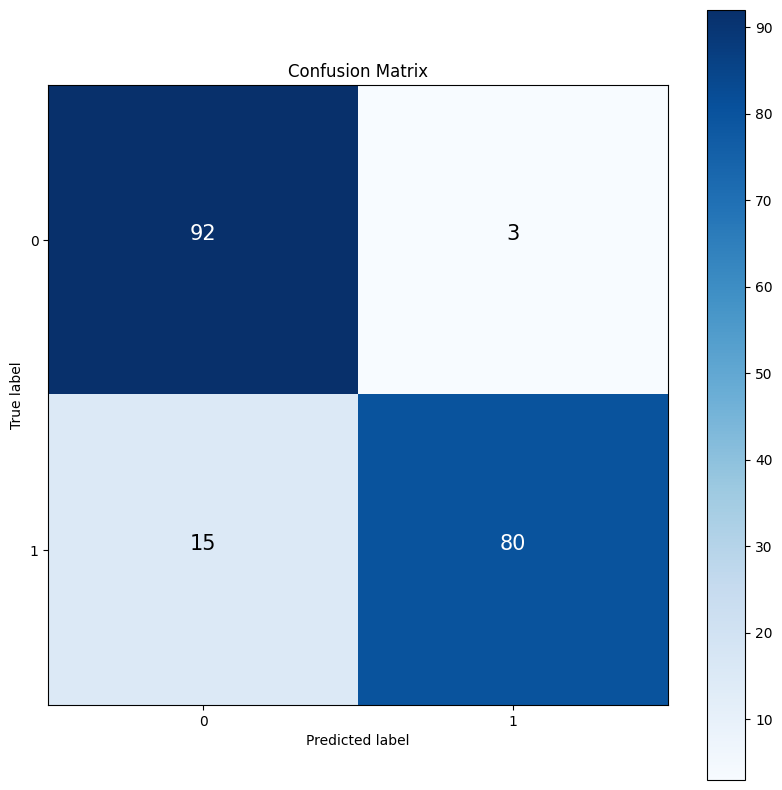


Accuracy: 0.9053, Precision: 0.9639, Recall: 0.8421, F1: 0.8989, AUC: 0.8989


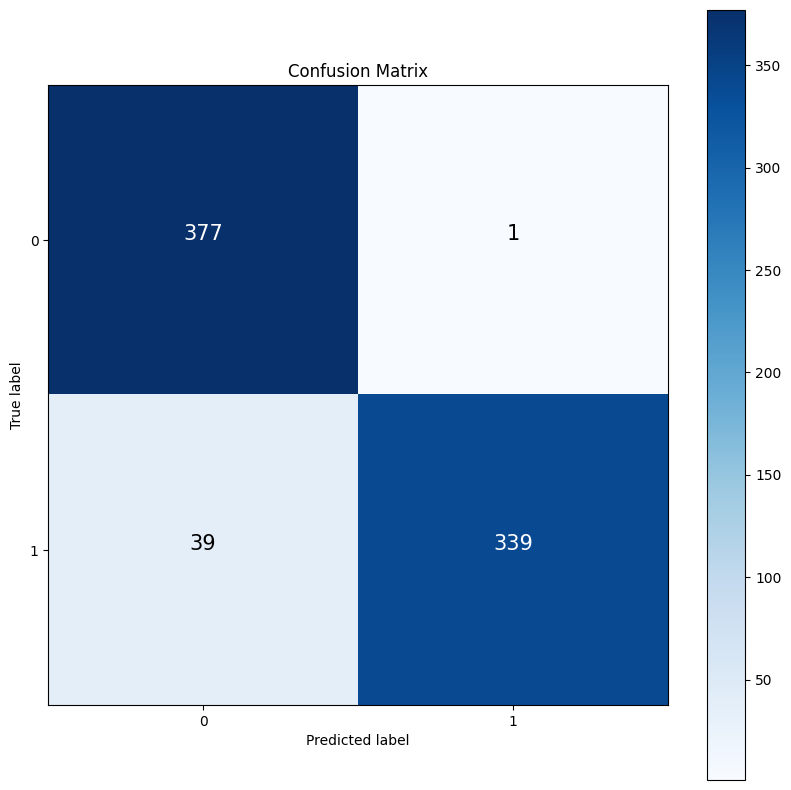


Accuracy: 0.9471, Precision: 0.9971, Recall: 0.8968, F1: 0.9443, AUC: 0.9443
------------------------
Performance of test data for model:  KNeighborsClassifier()
Initial RAM usage: 618.75390625 MB
Final RAM usage: 618.75390625 MB
RAM used during training: 0.0 MB
Fitting time: 1
Testing time: 14
Training time: 3


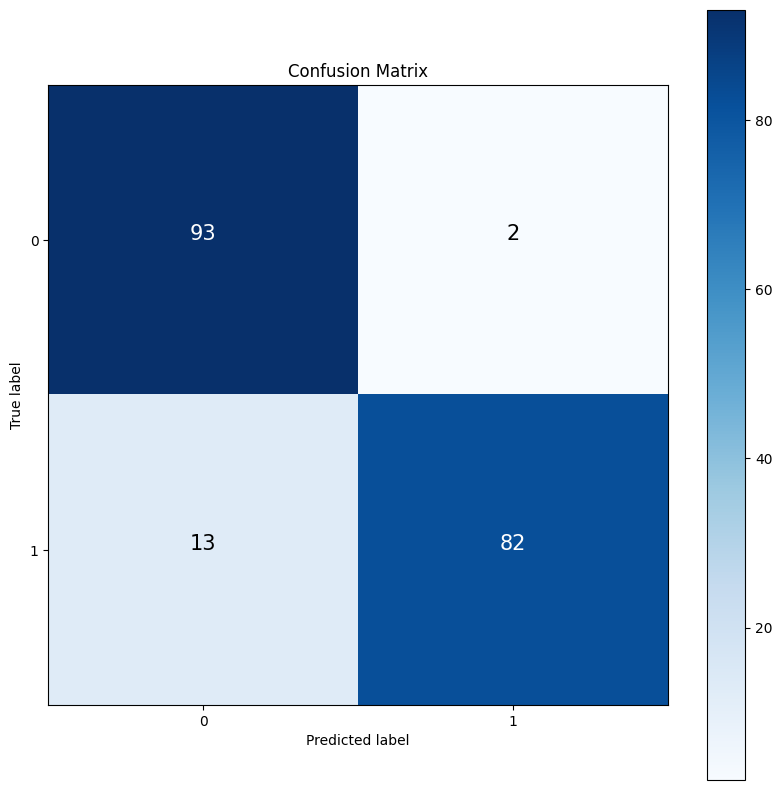


Accuracy: 0.9211, Precision: 0.9762, Recall: 0.8632, F1: 0.9162, AUC: 0.9162


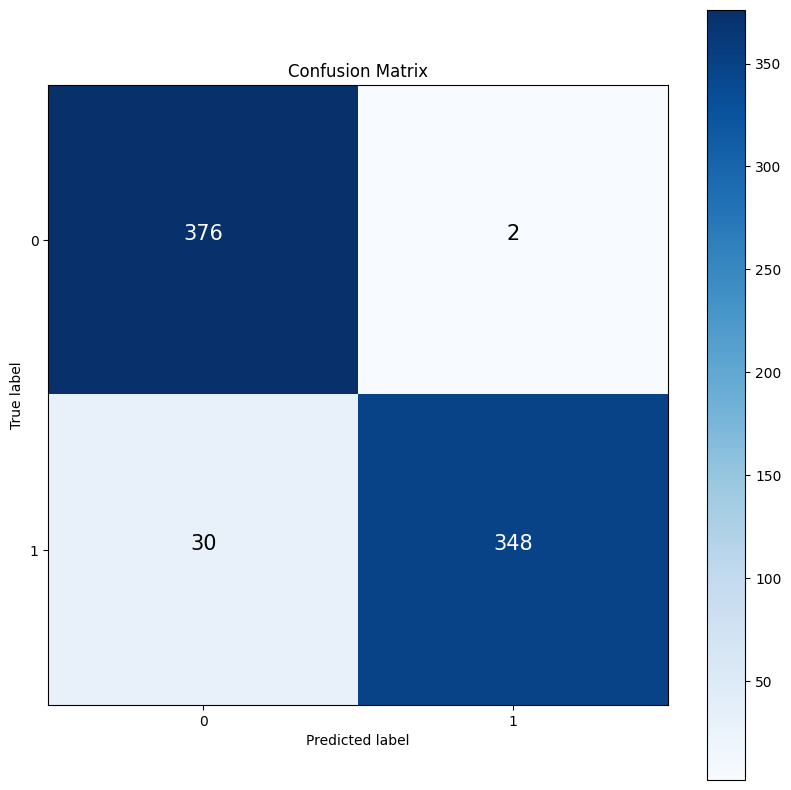


Accuracy: 0.9577, Precision: 0.9943, Recall: 0.9206, F1: 0.9560, AUC: 0.9560
------------------------
Performance of test data for model:  RandomForestClassifier(random_state=0)
Initial RAM usage: 619.25390625 MB
Final RAM usage: 619.75390625 MB
RAM used during training: 0.5 MB
Fitting time: 251
Testing time: 6
Training time: 7


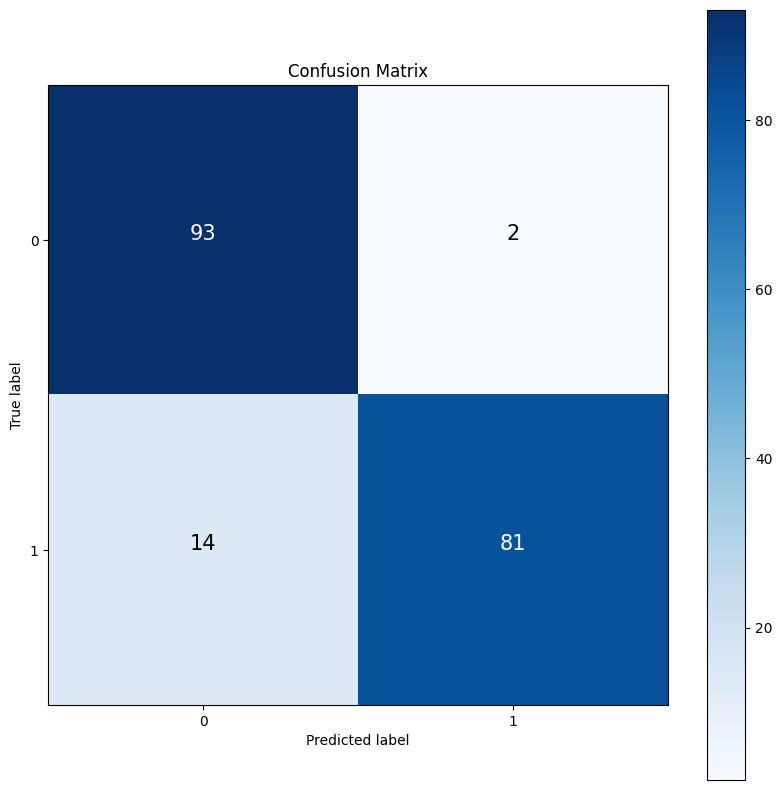


Accuracy: 0.9158, Precision: 0.9759, Recall: 0.8526, F1: 0.9101, AUC: 0.9101


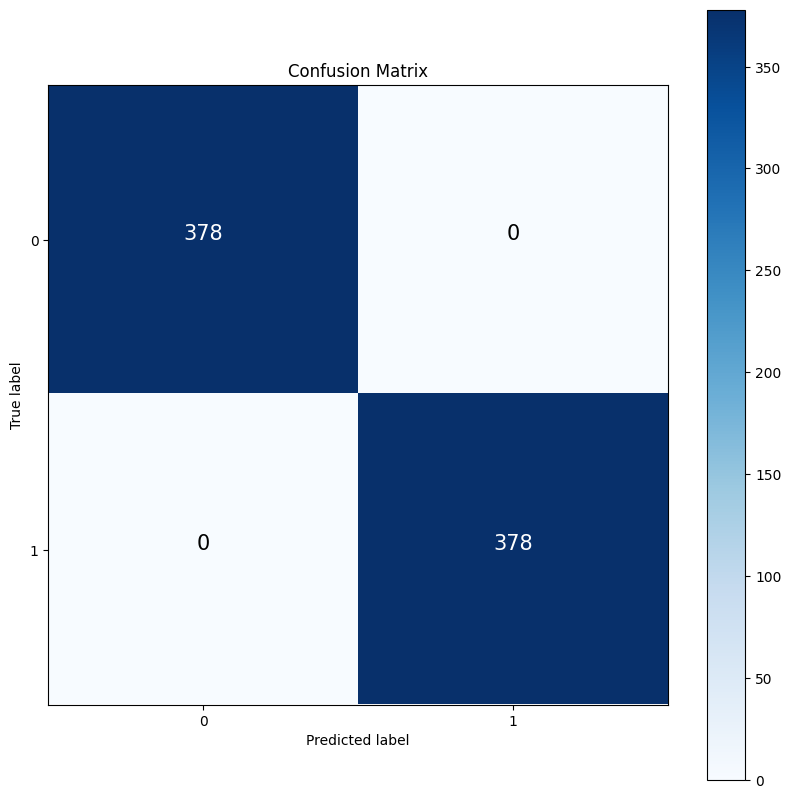


Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
------------------------
Performance of test data for model:  BaggingClassifier()
Initial RAM usage: 620.50390625 MB
Final RAM usage: 620.62890625 MB
RAM used during training: 0.125 MB
Fitting time: 82
Testing time: 3
Training time: 2


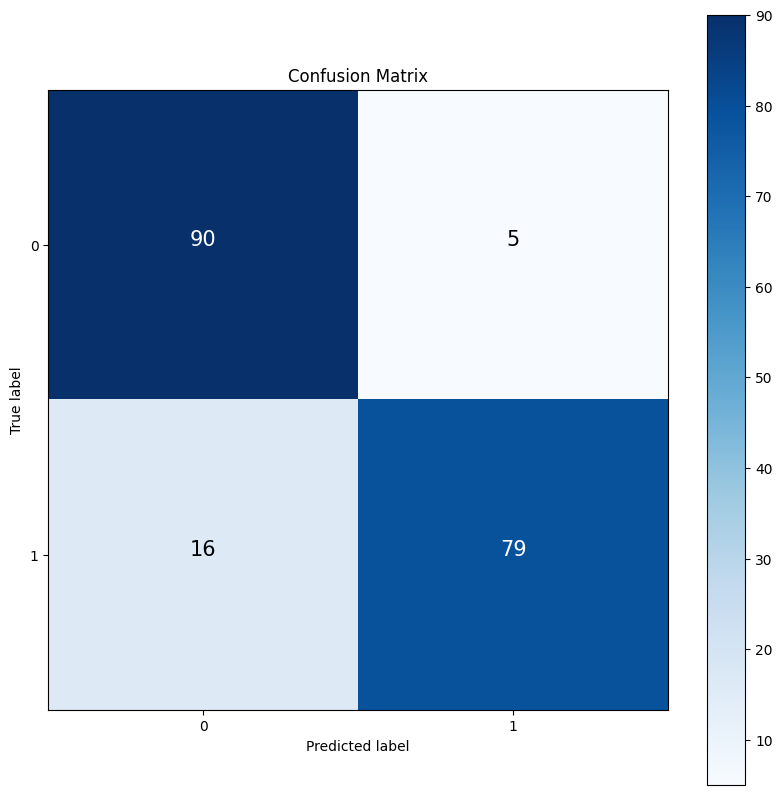


Accuracy: 0.8895, Precision: 0.9405, Recall: 0.8316, F1: 0.8827, AUC: 0.8827


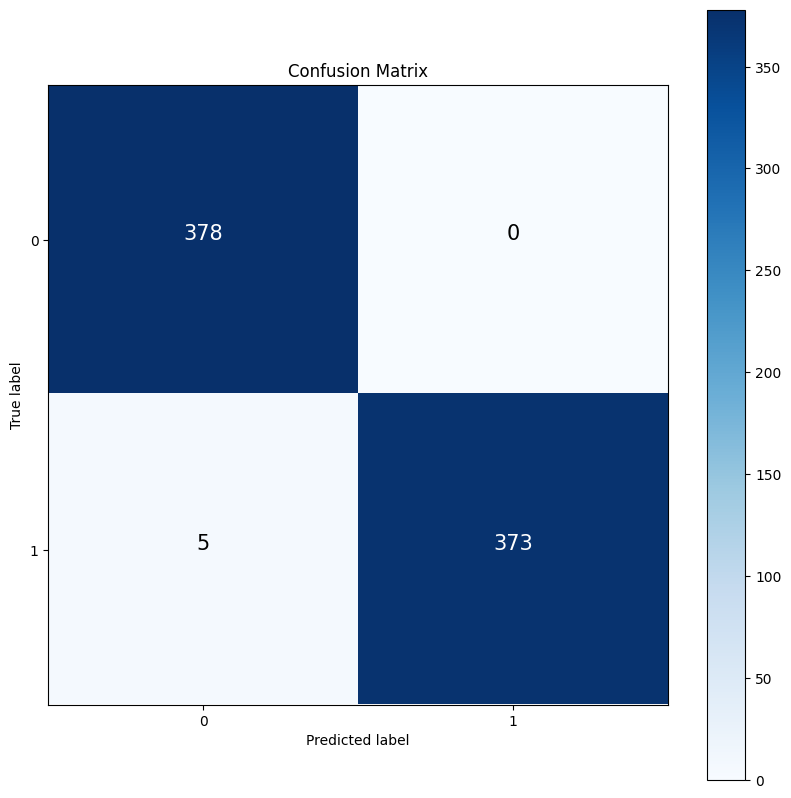


Accuracy: 0.9934, Precision: 1.0000, Recall: 0.9868, F1: 0.9933, AUC: 0.9933
------------------------
Performance of test data for model:  AdaBoostClassifier(estimator=RandomForestClassifier(random_state=0),
                   learning_rate=1, random_state=0)
Initial RAM usage: 620.75390625 MB
Final RAM usage: 620.75390625 MB
RAM used during training: 0.0 MB
Fitting time: 260
Testing time: 6
Training time: 6


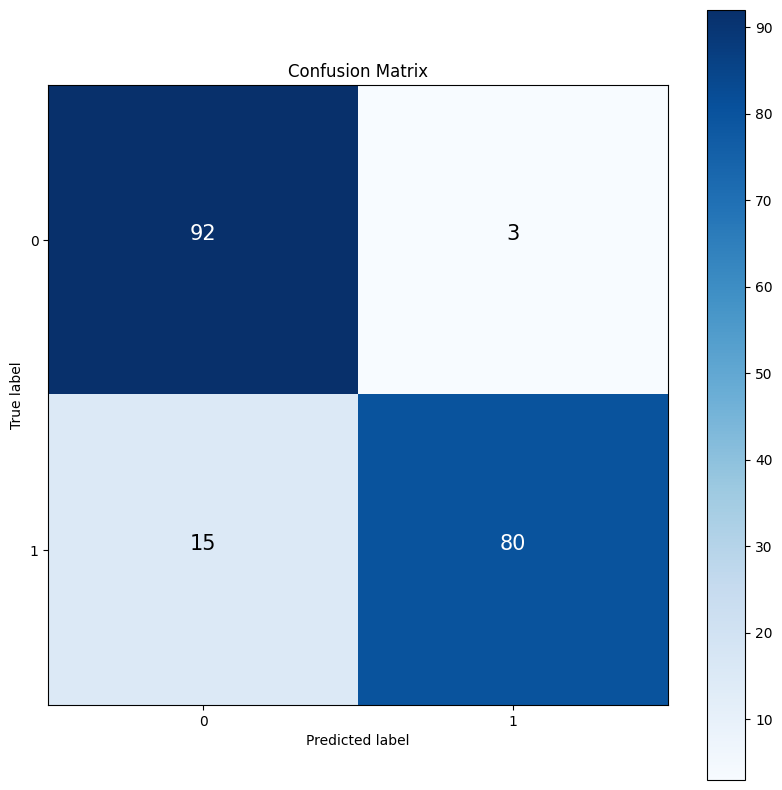


Accuracy: 0.9053, Precision: 0.9639, Recall: 0.8421, F1: 0.8989, AUC: 0.8989


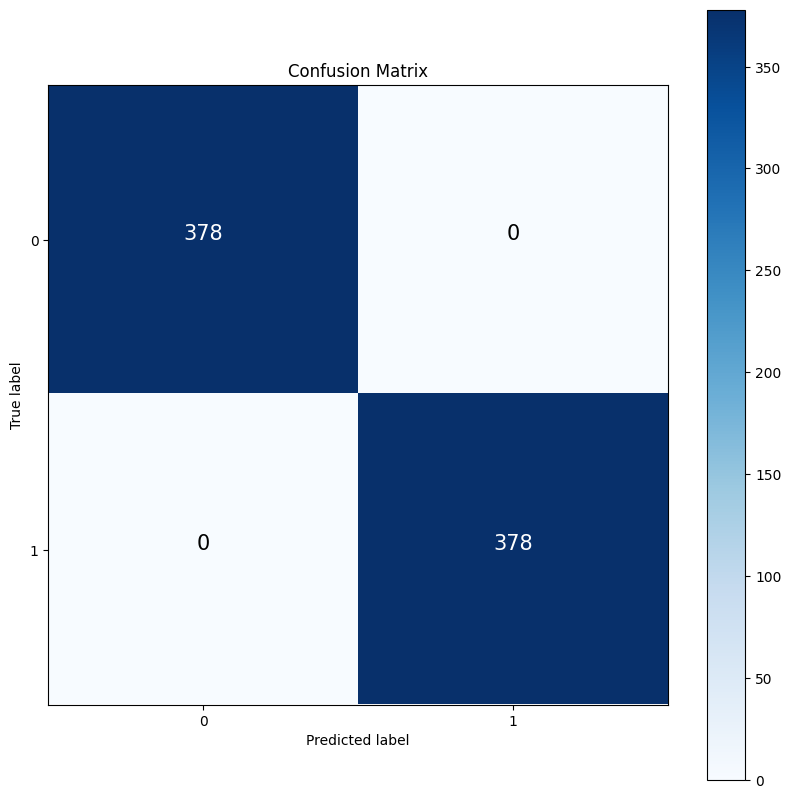


Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
------------------------
Performance of test data for model:  VotingClassifier(estimators=[('SVM', SVC(probability=True, random_state=0)),
                             ('KNN', KNeighborsClassifier()),
                             ('RF', RandomForestClassifier(random_state=0)),
                             ('BaggingClassifier', BaggingClassifier()),
                             ('AdaBoostClassifier',
                              AdaBoostClassifier(estimator=RandomForestClassifier(random_state=0),
                                                 learning_rate=1,
                                                 random_state=0))],
                 voting='soft')
Initial RAM usage: 621.50390625 MB
Final RAM usage: 621.62890625 MB
RAM used during training: 0.125 MB
Fitting time: 634
Testing time: 18
Training time: 25


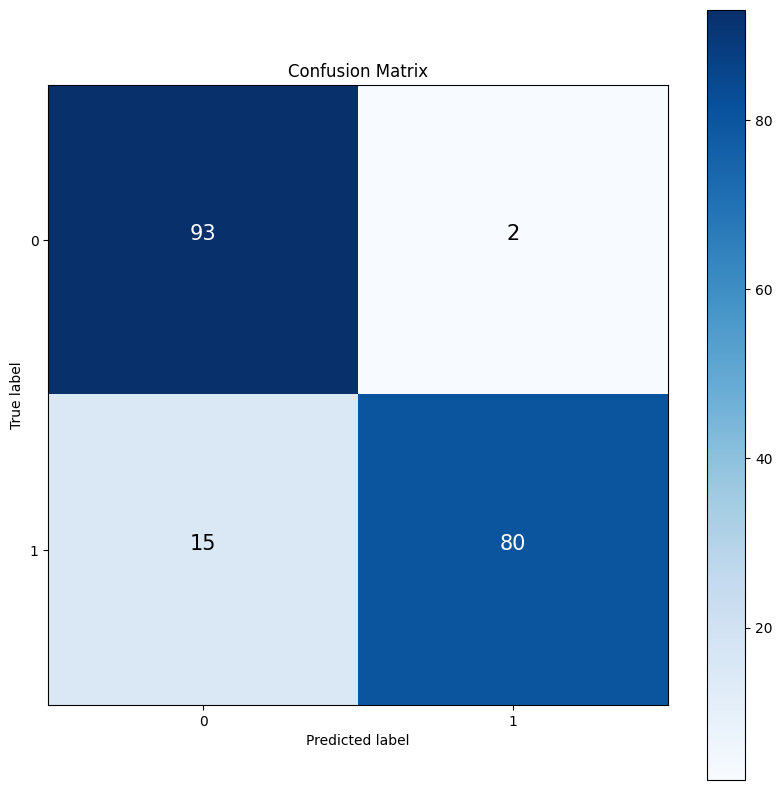


Accuracy: 0.9105, Precision: 0.9756, Recall: 0.8421, F1: 0.9040, AUC: 0.9040


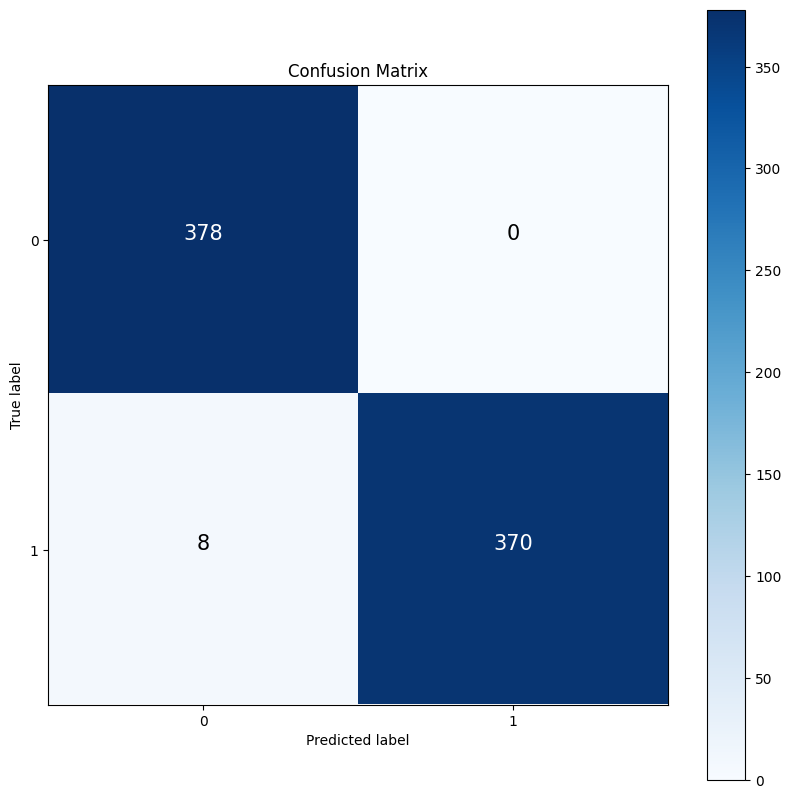


Accuracy: 0.9894, Precision: 1.0000, Recall: 0.9788, F1: 0.9893, AUC: 0.9893
------------------------
Performance of test data for model:  LogisticRegression(random_state=0)
Initial RAM usage: 622.25390625 MB
Final RAM usage: 624.82421875 MB
RAM used during training: 2.5703125 MB
Fitting time: 39
Testing time: 2
Training time: 0


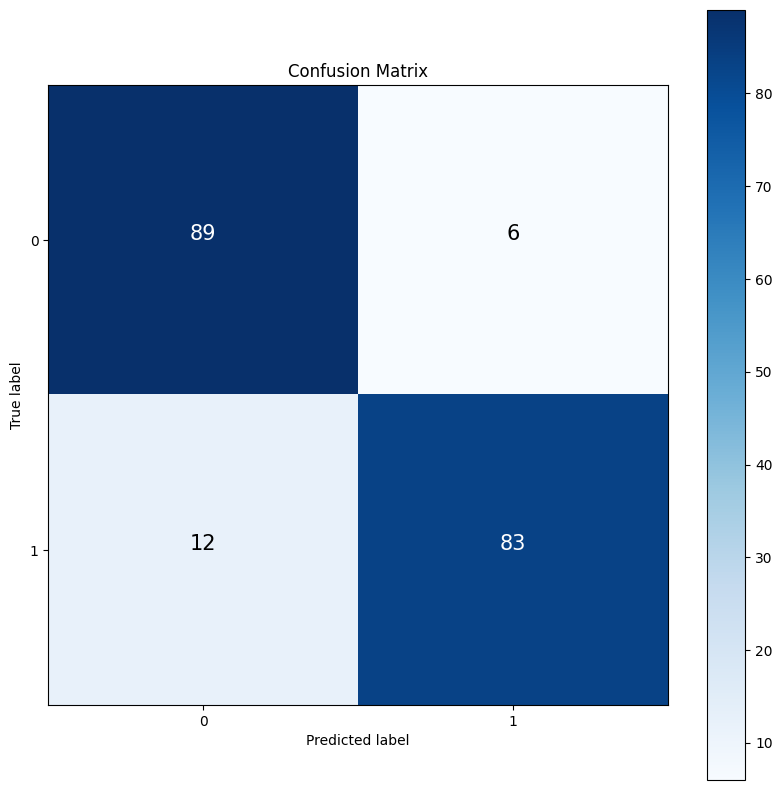


Accuracy: 0.9053, Precision: 0.9326, Recall: 0.8737, F1: 0.9022, AUC: 0.9022


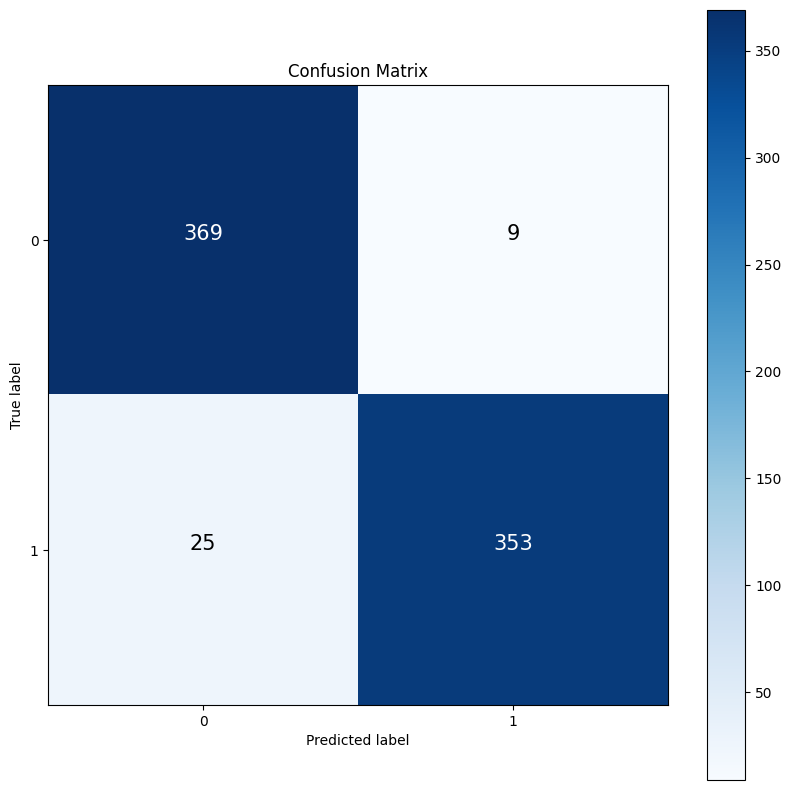


Accuracy: 0.9550, Precision: 0.9751, Recall: 0.9339, F1: 0.9541, AUC: 0.9541
------------------------
Performance of test data for model:  VotingClassifier(estimators=[('LR', LogisticRegression(random_state=0)),
                             ('KNN', KNeighborsClassifier()),
                             ('RF', RandomForestClassifier(random_state=0)),
                             ('BaggingClassifier', BaggingClassifier()),
                             ('AdaBoostClassifier',
                              AdaBoostClassifier(estimator=RandomForestClassifier(random_state=0),
                                                 learning_rate=1,
                                                 random_state=0))],
                 voting='soft')
Initial RAM usage: 626.07421875 MB
Final RAM usage: 626.07421875 MB
RAM used during training: 0.0 MB
Fitting time: 673
Testing time: 17
Training time: 27


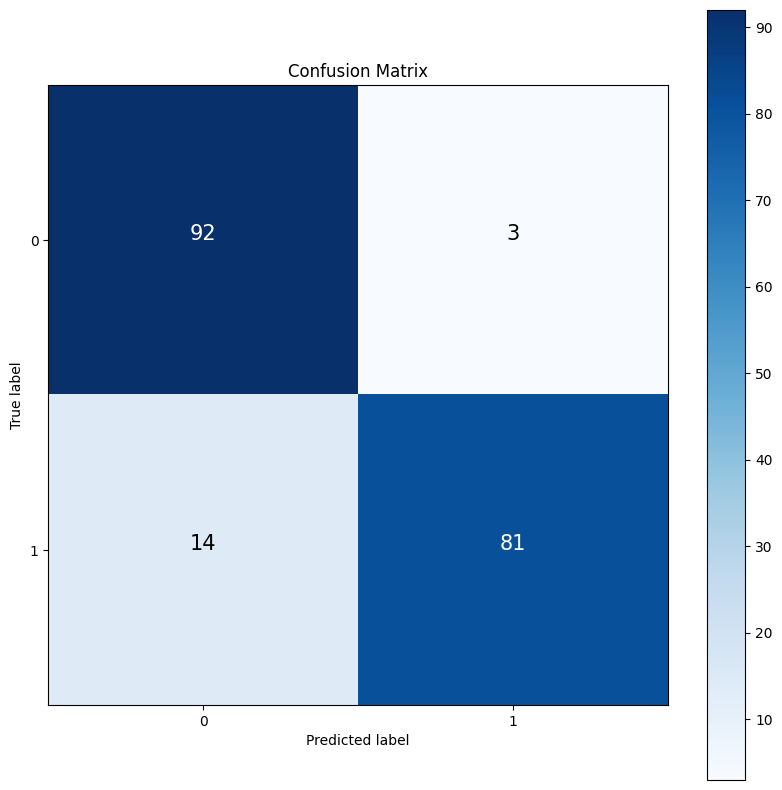


Accuracy: 0.9105, Precision: 0.9643, Recall: 0.8526, F1: 0.9050, AUC: 0.9050


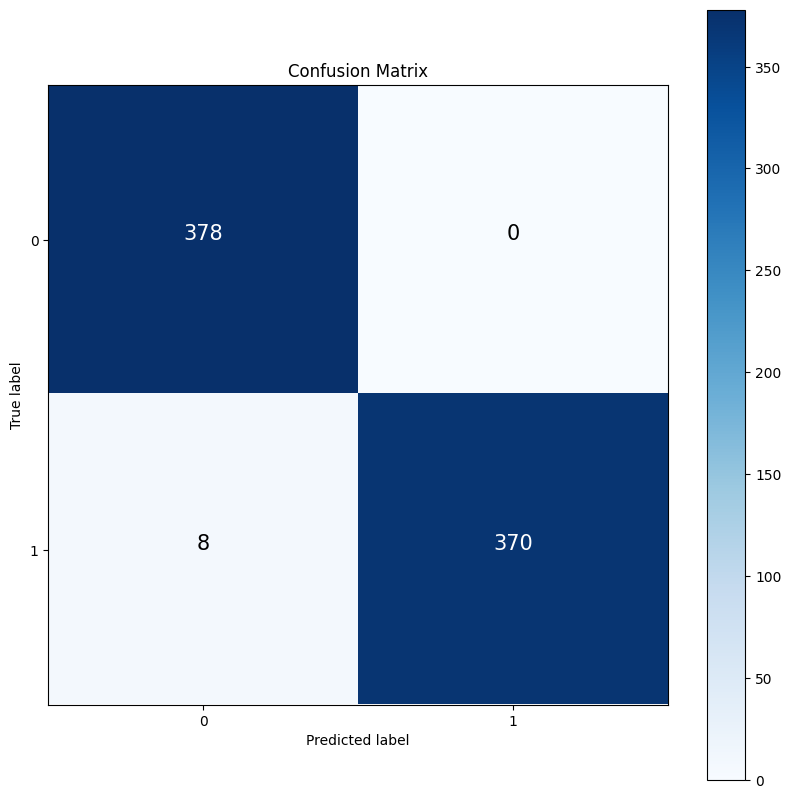


Accuracy: 0.9894, Precision: 1.0000, Recall: 0.9788, F1: 0.9893, AUC: 0.9893
------------------------


In [29]:
from sklearn.metrics import RocCurveDisplay

models = [SVM_model, knn_model, rf_model,bagging_model,adaboosting_model, voting_class_1, lr_model, voting_class_2]
models_name = ["SVM", "KNN", "RF", "Bagging", "Adaboost", "P_M_1", "LR", "P_M_2"]
precisions_test = []
precisions_train = []
recalls_test = []
recalls_train = []
accuracy_train = []
f1s_test = []
f1s_train = []
accuracy_test = []
times_fit = []
times_train = []
times_test = []
for model in models:
    if model == knn_model:
        X_test = np.ascontiguousarray(X_test)
        X_train_under = np.ascontiguousarray(X_train_under)
    print("Performance of test data for model: ", model)
    precision_train, recall_train, f1_train, acc_train, precision_test, recall_test, f1_test, acc_test, time_train, time_test, time_fit = train_model(model, ftr_train=X_train_under, ftr_test=X_test_under, tgt_train=y_train_under, tgt_test=y_test_under)
    precisions_test.append(precision_test)
    precisions_train.append(precision_train)
    recalls_test.append(recall_test)
    recalls_train.append(recall_train)
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)
    f1s_test.append(f1_test)
    f1s_train.append(f1_train)
    times_fit.append(time_fit)
    times_train.append(time_train)
    times_test.append(time_test)


    print("------------------------")







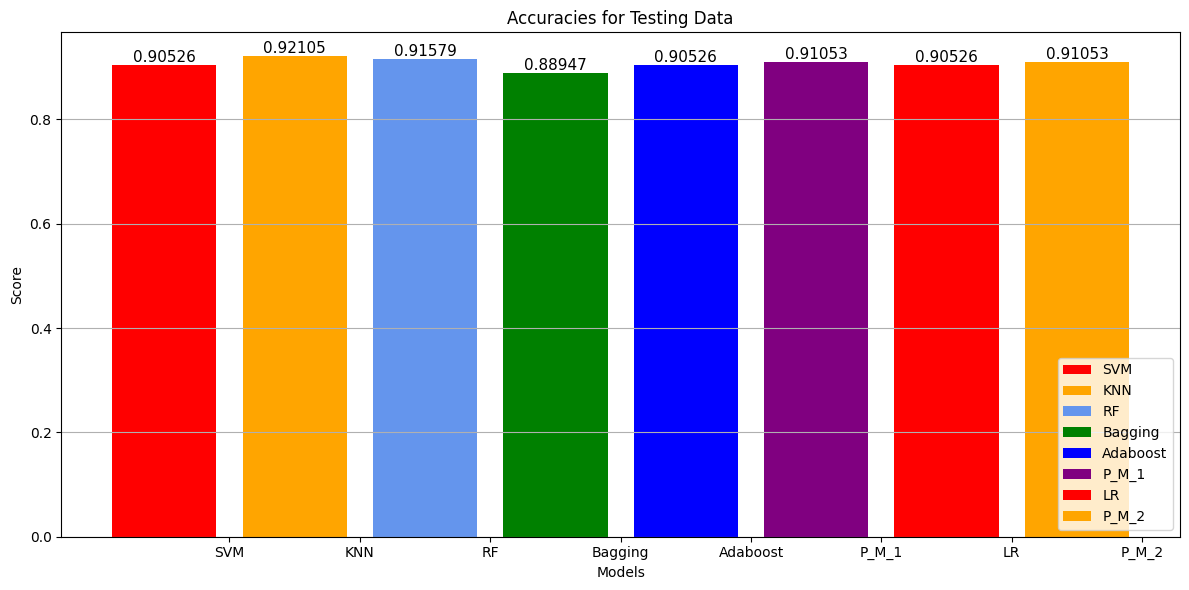

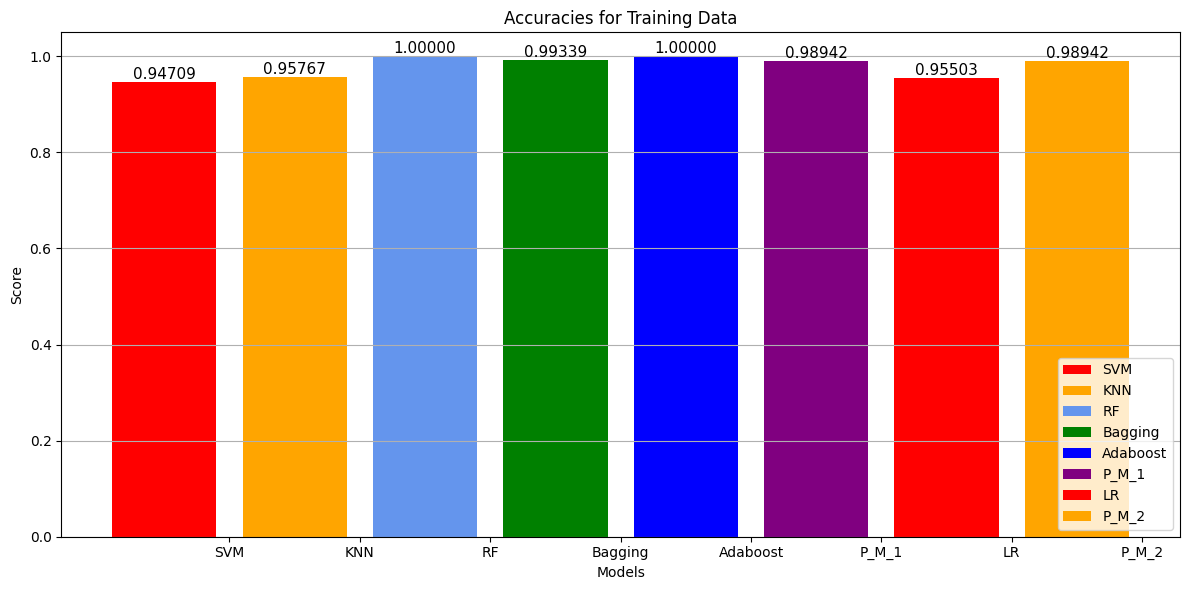

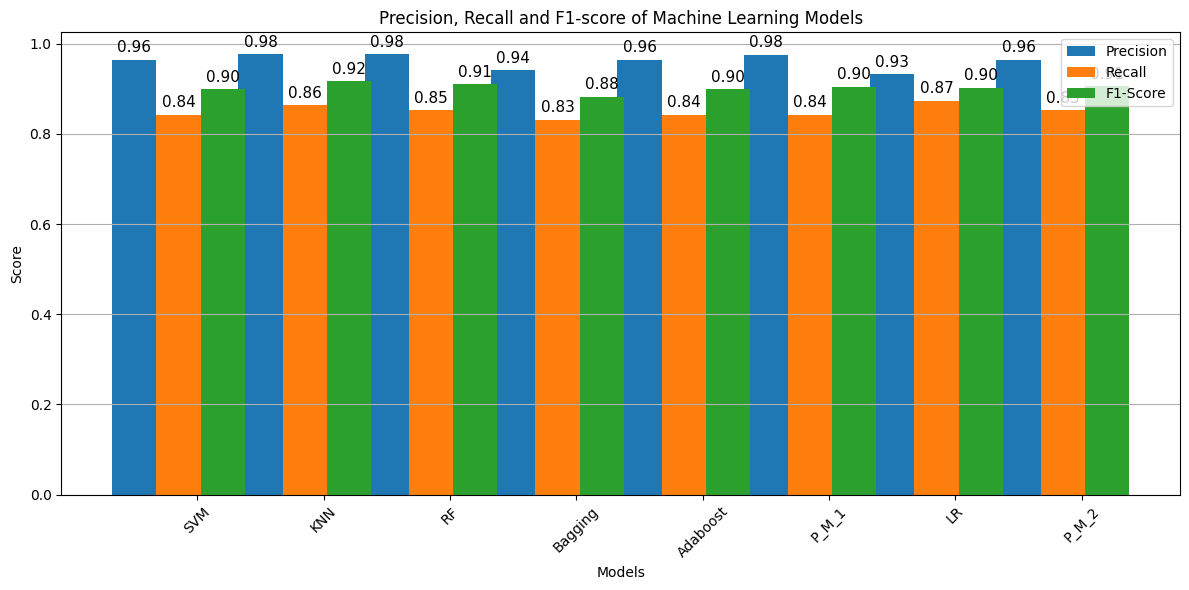

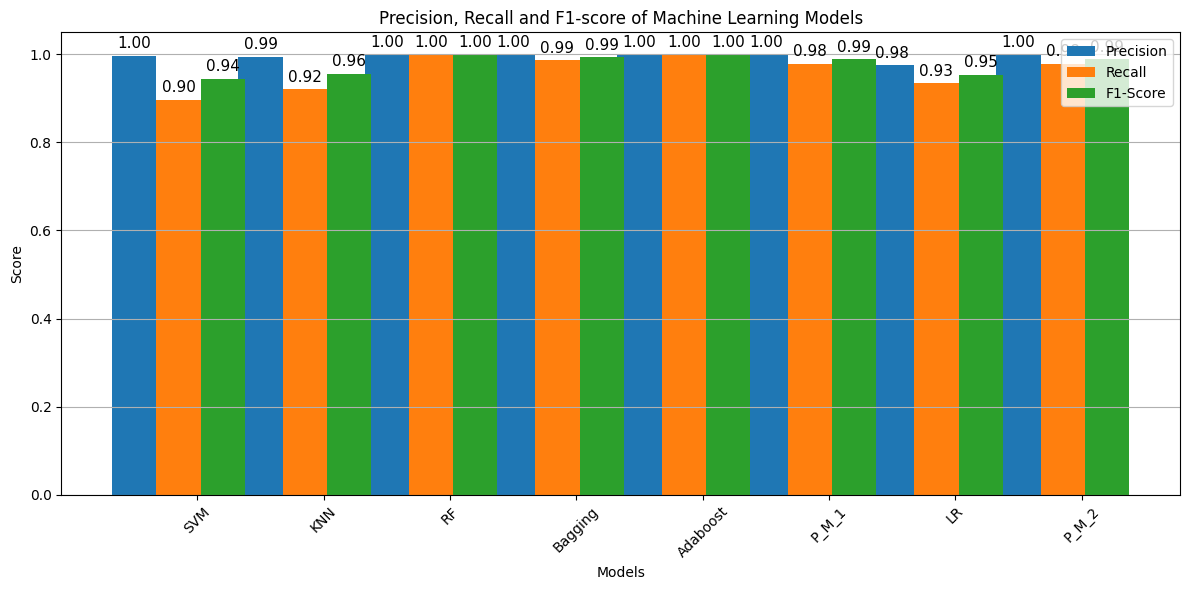

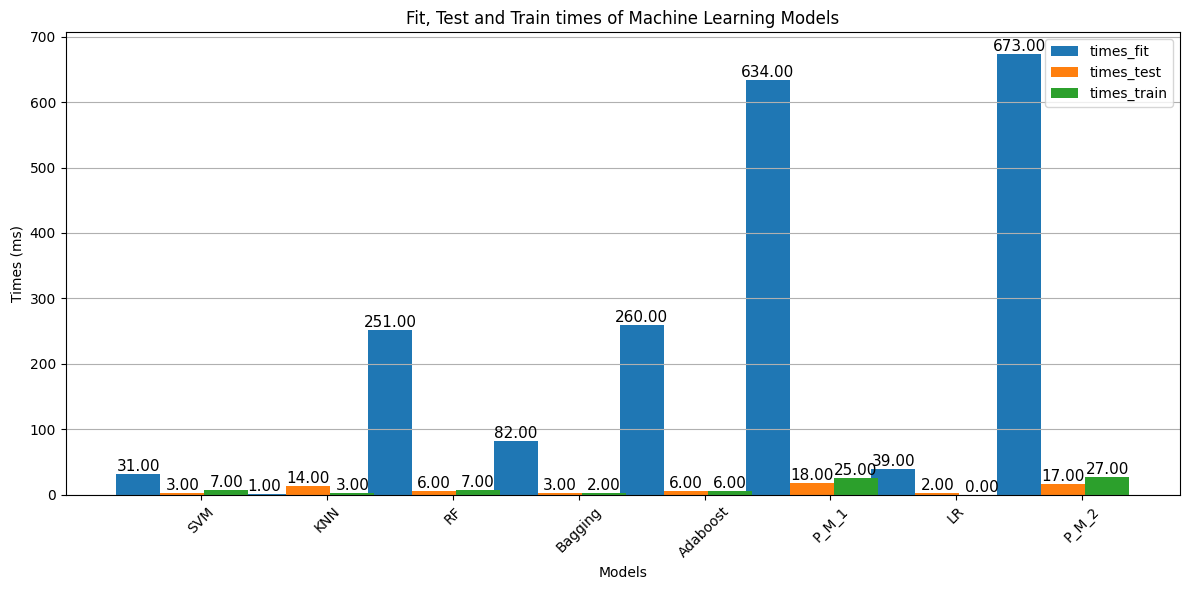

In [30]:
plot_accuracy(models_name, accuracy_test)
plot_accuracy(models_name, accuracy_train,False)
plots(models_name, precisions_test, recalls_test, f1s_test)
plots(models_name, precisions_train, recalls_train, f1s_train)
time_plots(models_name, times_fit, times_test, times_train)


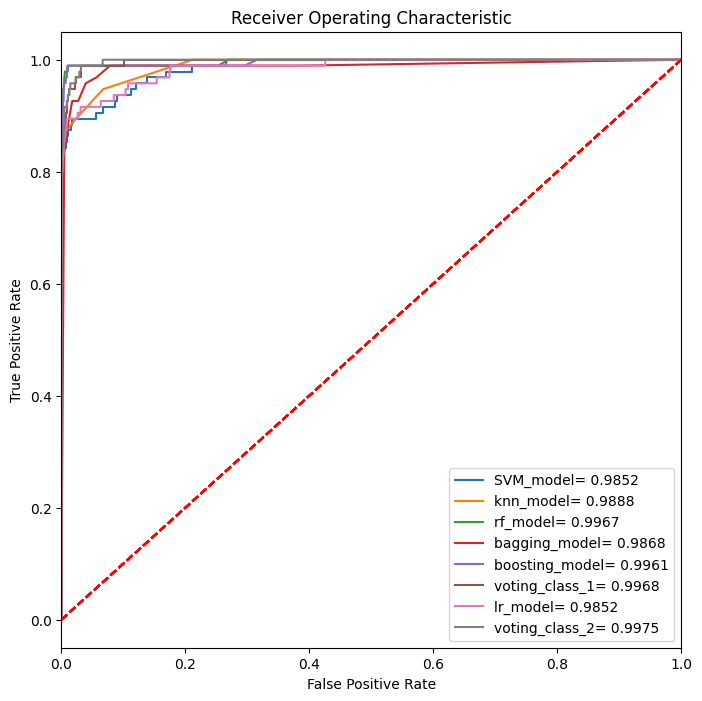

In [31]:
display_roc_curve(models, ftr_test=X_test, tgt_test=y_test)


knn_model = KNeighborsClassifier()

SMOTE oversampling applied
Performance of test data for model:  KNeighborsClassifier()
Initial RAM usage: 751.07421875 MB
Final RAM usage: 751.07421875 MB
RAM used during training: 0.0 MB
Fitting time: 22
Testing time: 100480
Training time: 403218


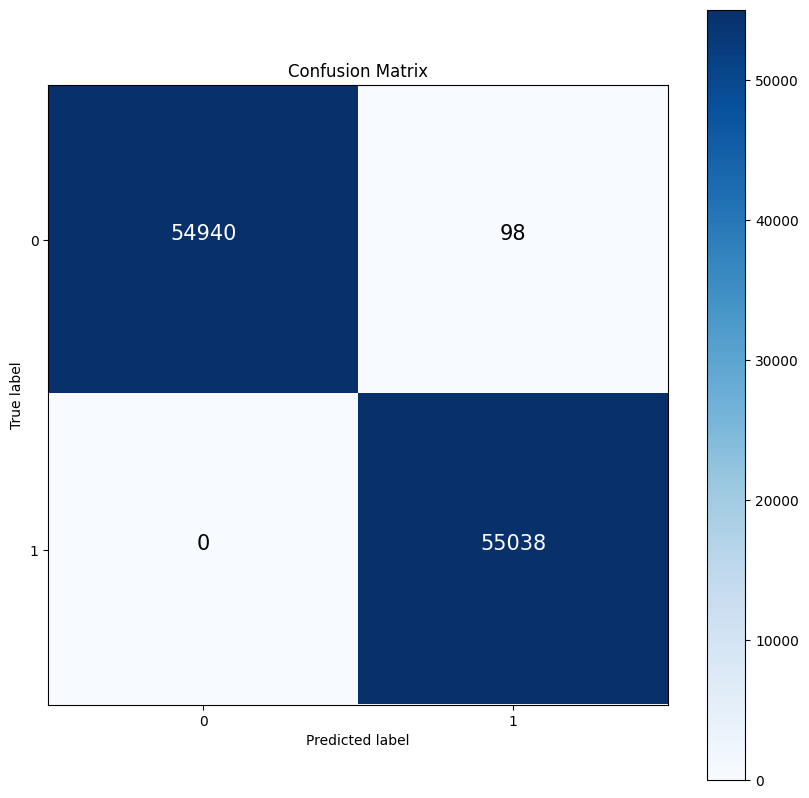


Accuracy: 0.9991, Precision: 0.9982, Recall: 1.0000, F1: 0.9991, AUC: 0.9991


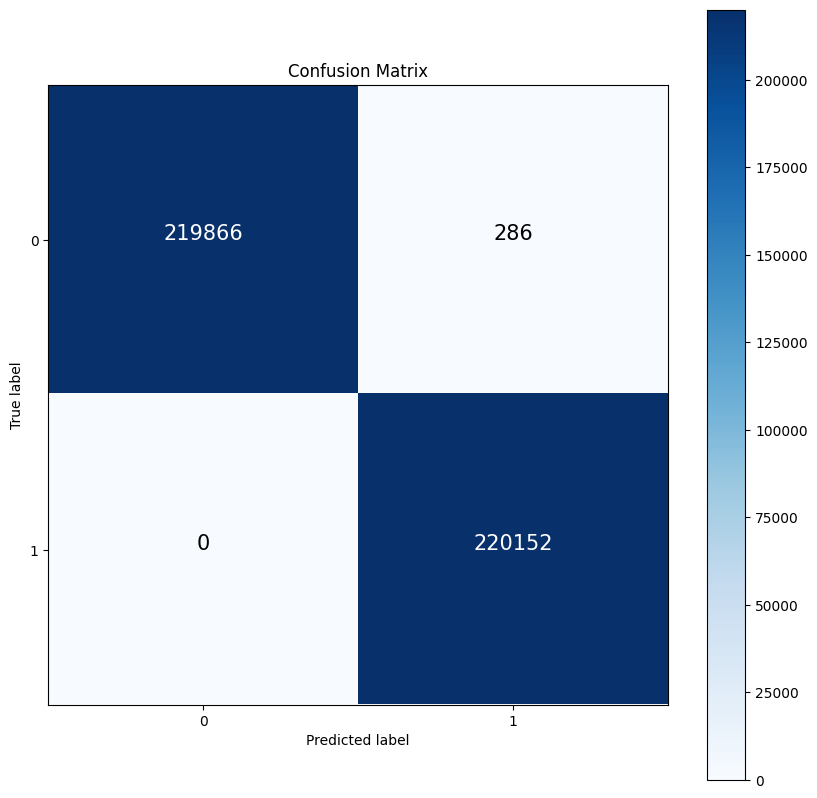


Accuracy: 0.9994, Precision: 0.9987, Recall: 1.0000, F1: 0.9994, AUC: 0.9994
------------------------
Performance of test data for model:  RandomForestClassifier(random_state=0)
Initial RAM usage: 751.19921875 MB
Final RAM usage: 751.19921875 MB
RAM used during training: 0.0 MB
Fitting time: 343104
Testing time: 678
Training time: 2675


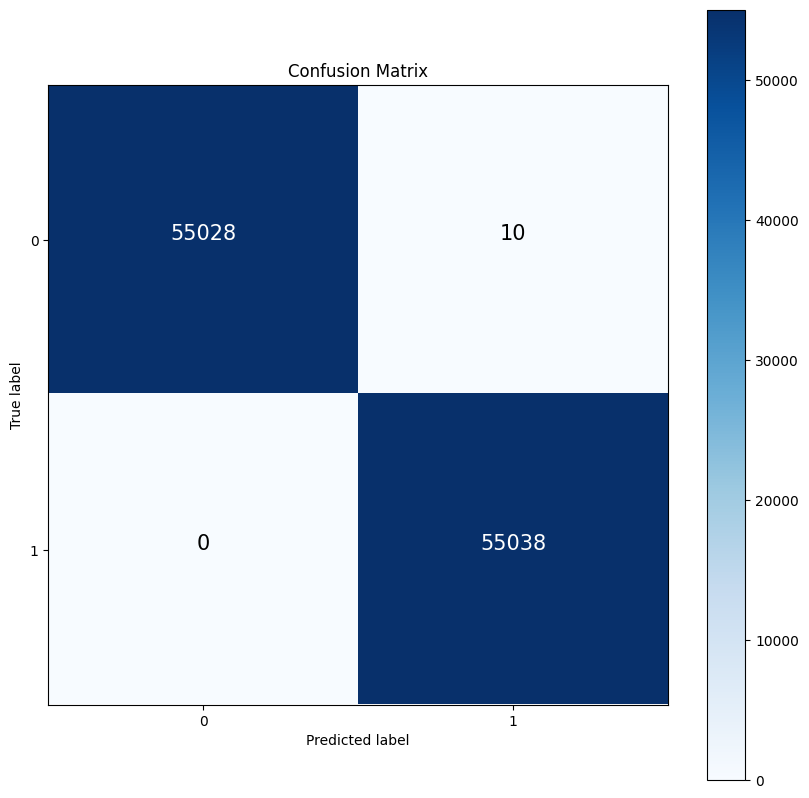


Accuracy: 0.9999, Precision: 0.9998, Recall: 1.0000, F1: 0.9999, AUC: 0.9999


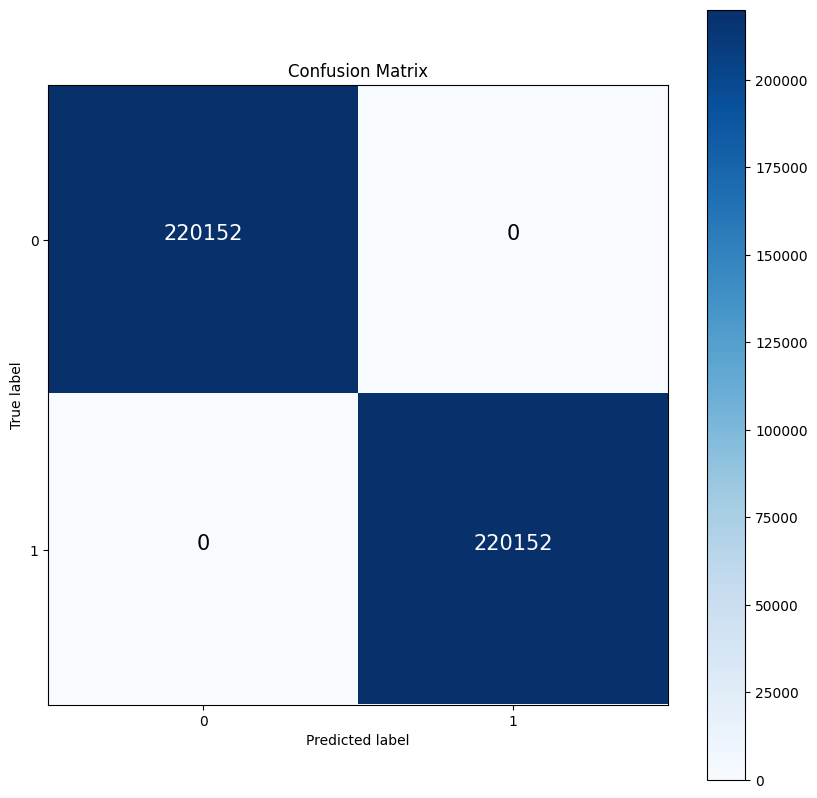


Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
------------------------
Performance of test data for model:  BaggingClassifier()
Initial RAM usage: 751.19921875 MB
Final RAM usage: 751.44921875 MB
RAM used during training: 0.25 MB
Fitting time: 231136
Testing time: 179
Training time: 892


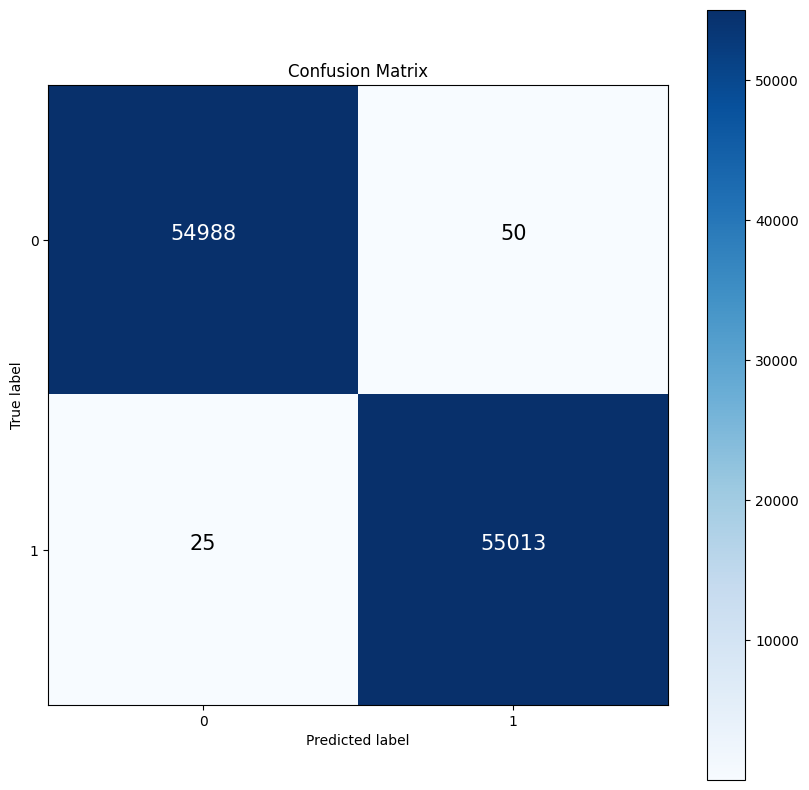


Accuracy: 0.9993, Precision: 0.9991, Recall: 0.9995, F1: 0.9993, AUC: 0.9993


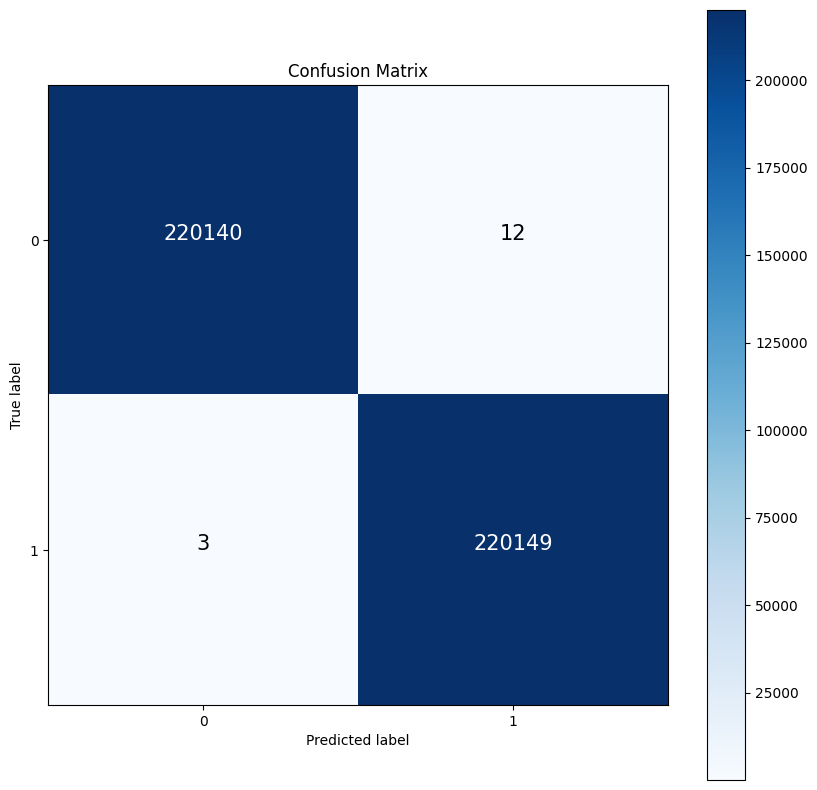


Accuracy: 1.0000, Precision: 0.9999, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
------------------------
Performance of test data for model:  GradientBoostingClassifier(random_state=0)
Initial RAM usage: 751.4609375 MB
Final RAM usage: 753.3359375 MB
RAM used during training: 1.875 MB
Fitting time: 614944
Testing time: 139
Training time: 568


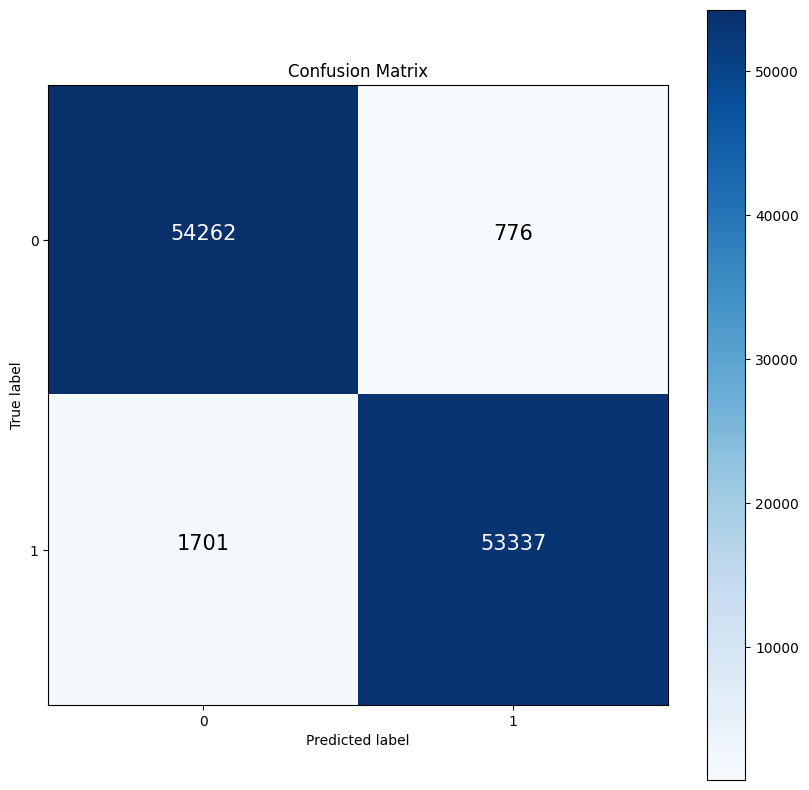


Accuracy: 0.9775, Precision: 0.9857, Recall: 0.9691, F1: 0.9773, AUC: 0.9773


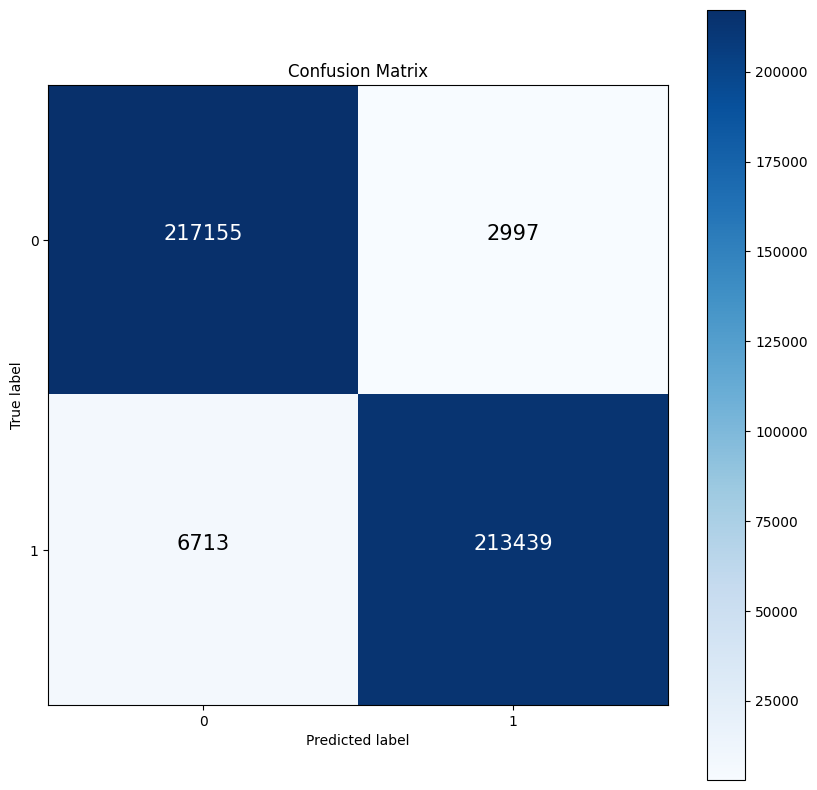


Accuracy: 0.9779, Precision: 0.9862, Recall: 0.9695, F1: 0.9778, AUC: 0.9778
------------------------
Performance of test data for model:  LogisticRegression(random_state=0)
Initial RAM usage: 753.4609375 MB
Final RAM usage: 753.4609375 MB
RAM used during training: 0.0 MB
Fitting time: 1285
Testing time: 3
Training time: 11


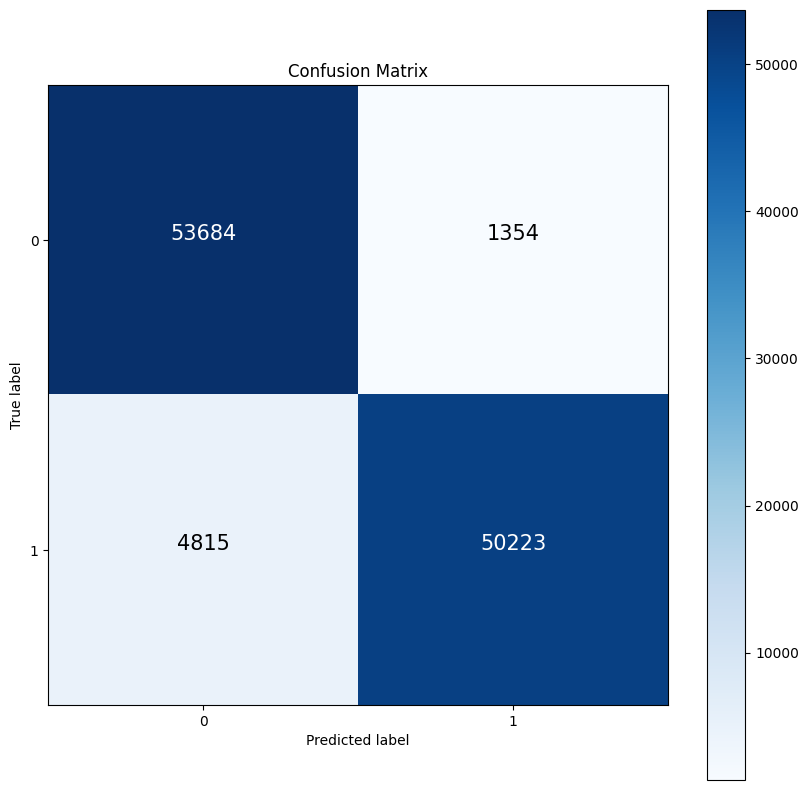


Accuracy: 0.9440, Precision: 0.9737, Recall: 0.9125, F1: 0.9421, AUC: 0.9421


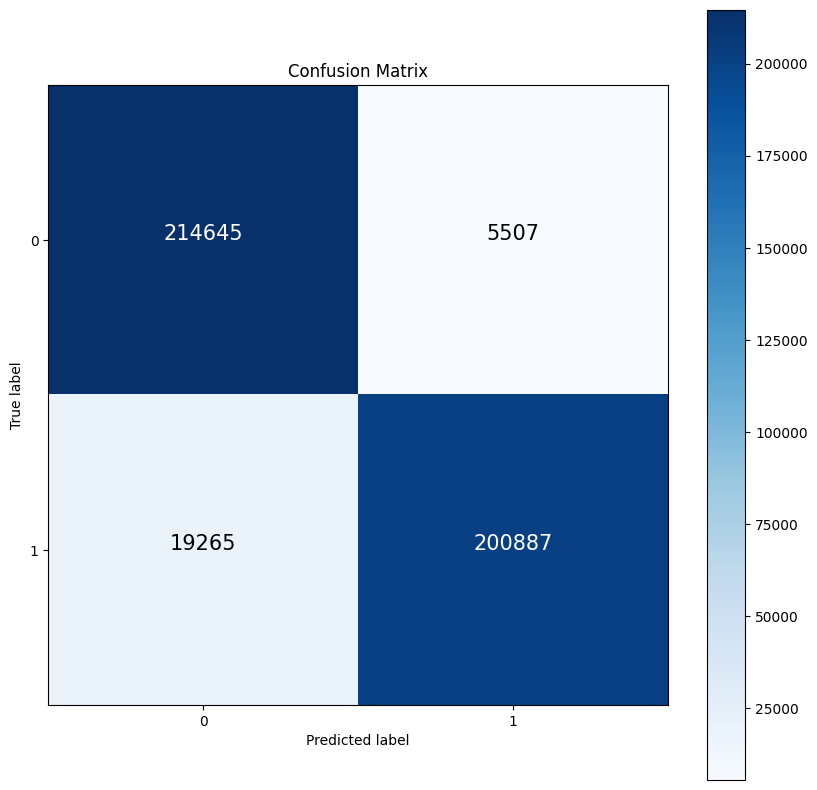


Accuracy: 0.9437, Precision: 0.9733, Recall: 0.9125, F1: 0.9419, AUC: 0.9419
------------------------
Performance of test data for model:  VotingClassifier(estimators=[('LR', LogisticRegression(random_state=0)),
                             ('KNN', KNeighborsClassifier()),
                             ('RF', RandomForestClassifier(random_state=0)),
                             ('BaggingClassifier', BaggingClassifier()),
                             ('AdaBoostClassifier',
                              AdaBoostClassifier(estimator=RandomForestClassifier(random_state=0),
                                                 learning_rate=1,
                                                 random_state=0))],
                 voting='soft')
Initial RAM usage: 753.5859375 MB
Final RAM usage: 763.5546875 MB
RAM used during training: 9.96875 MB
Fitting time: 885258
Testing time: 100945
Training time: 405646


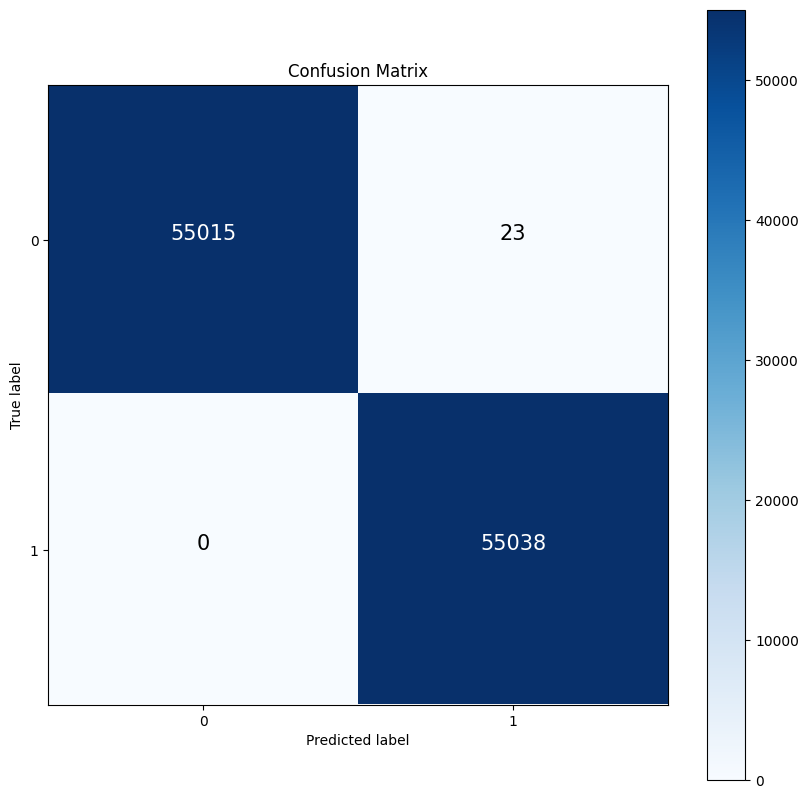


Accuracy: 0.9998, Precision: 0.9996, Recall: 1.0000, F1: 0.9998, AUC: 0.9998


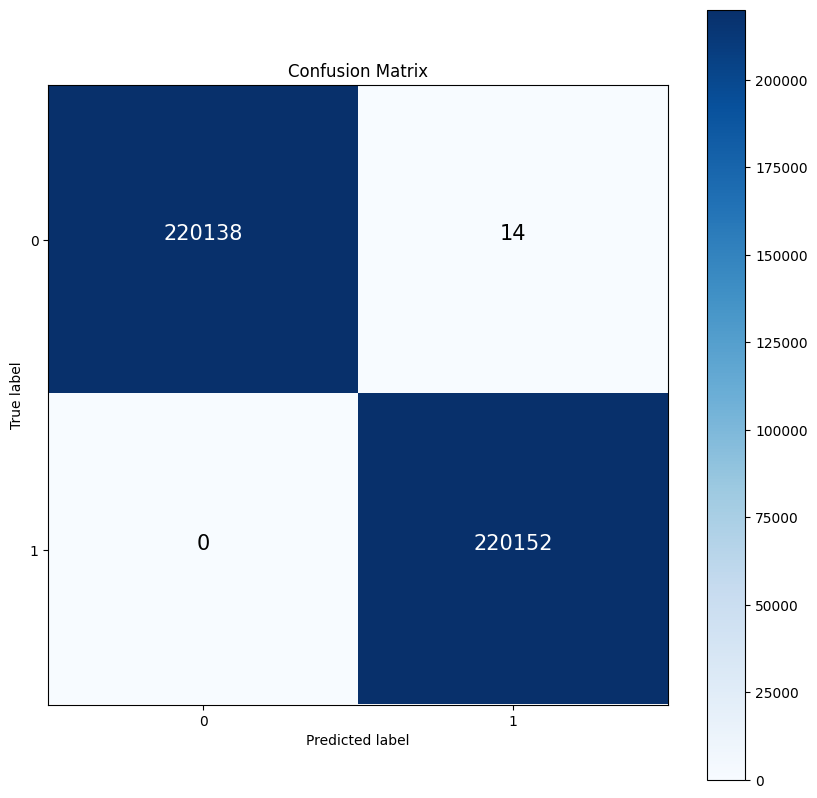

: 

In [32]:
print('SMOTE oversampling applied')
models = [knn_model, rf_model,bagging_model,boosting_model, lr_model, voting_class_2]
precisions_test = []
precisions_train = []
recalls_test = []
recalls_train = []
accuracy_train = []
f1s_test = []
f1s_train = []
accuracy_test = []
times_fit = []
times_train = []
times_test = []
start_time = time.time()
for model in models:
    if model == knn_model:
        X_test_over = np.ascontiguousarray(X_test_over)
        X_train_over = np.ascontiguousarray(X_train_over)
    print("Performance of test data for model: ", model)
    precision_train, recall_train, f1_train, acc_train, precision_test, recall_test, f1_test, acc_test, time_train, time_test, time_fit = train_model(model, ftr_train=X_train_over, ftr_test=X_test_over, tgt_train=y_train_over, tgt_test=y_test_over)
    precisions_test.append(precision_test)
    precisions_train.append(precisions_train)
    recalls_test.append(recall_test)
    recalls_train.append(recall_train)
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)
    f1s_test.append(f1_test)
    f1s_train.append(f1_train)
    times_fit.append(time_fit)
    times_train.append(time_train) 
    times_test.append(time_test)
    print("------------------------")
end_time = time.time()
print(end_time-start_time)

np.savetxt('precisions_train.txt', precisions_train, delimiter=',')
np.savetxt('recalls_train.txt', recalls_train, delimiter=',')
np.savetxt('accuracy_train.txt', accuracy_train, delimiter=',')
np.savetxt('f1s_train.txt', f1s_train, delimiter=',')




In [ ]:
display_roc_curve_SMOTE(models, ftr_test=X_test_over, tgt_test=y_test_over)

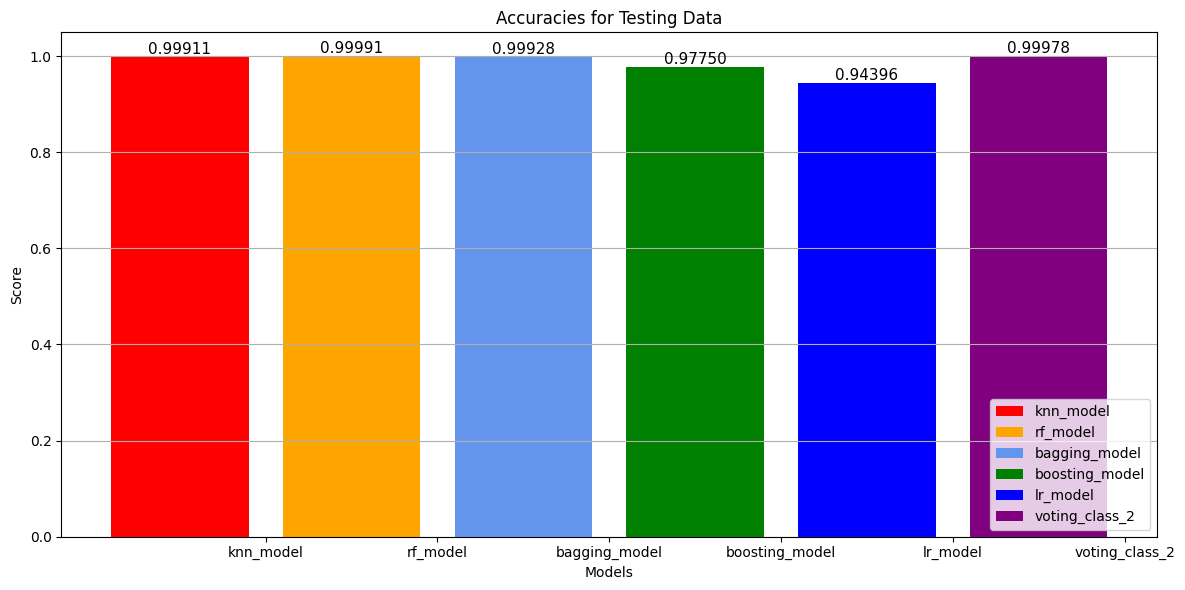

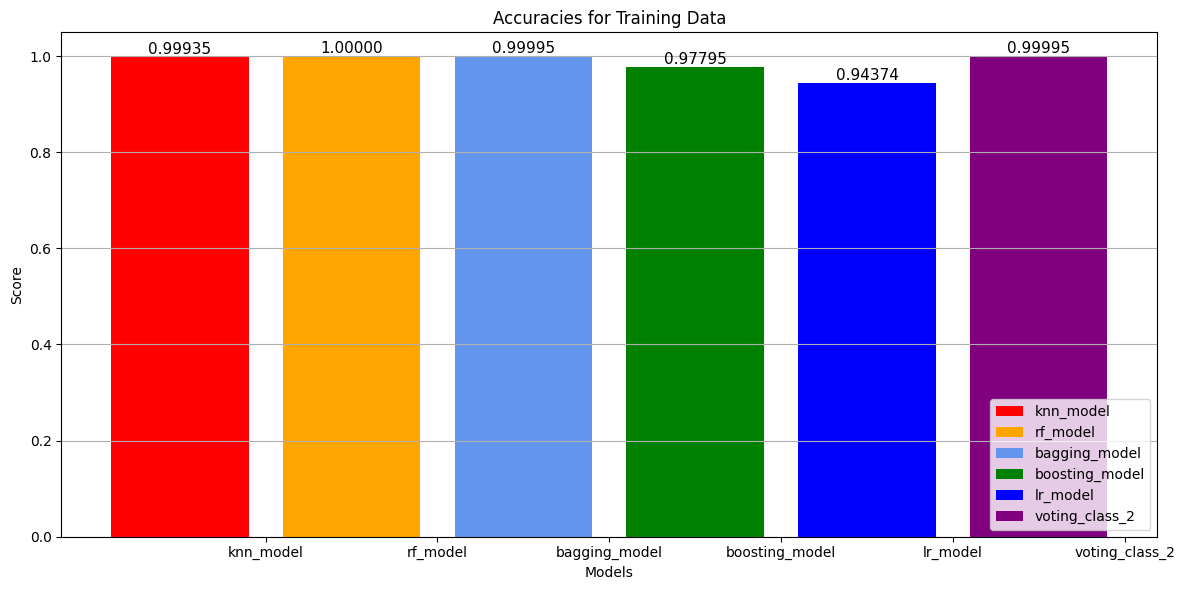

In [ ]:
models_name = ["knn_model", "rf_model","bagging_model","boosting_model", "lr_model", "voting_class_2"]
plot_accuracy(models_name, accuracy_test,smote=True)
plot_accuracy(models_name, accuracy_train,False,smote=True)
plots(models_name, precisions_test, recalls_test, f1s_test)
plots(models_name, precisions_train, recalls_train, f1s_train)
time_plots(models_name, times_fit, times_test, times_train)


display_roc_curve_SMOTE(models, ftr_test=X_test_over, tgt_test=y_test_over)